In [10]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Beautiful global style
sns.set_theme(style="whitegrid", palette="viridis")


# ------------------------------------------------
# 1. FILE PATHS
# ------------------------------------------------

FILE_PATHS = {
    2019: "/Users/randalburks/Downloads/FALL 2025/482/final project/play_by_play_2019.csv",
    2020: "/Users/randalburks/Downloads/FALL 2025/482/final project/play_by_play_2020.csv",
    2021: "/Users/randalburks/Downloads/FALL 2025/482/final project/play_by_play_2021.csv",
    2023: "/Users/randalburks/Downloads/FALL 2025/482/final project/play_by_play_2023.csv",
}

BASE_DIR = os.path.dirname(next(iter(FILE_PATHS.values())))



# ------------------------------------------------
# 2. LOAD & CLEAN DATA
# ------------------------------------------------

def load_pbp_data(file_paths):
    tables = []
    for season, path in file_paths.items():
        print(f"Loading season {season} from {path} ...")
        df = pd.read_csv(path, low_memory=False)
        df["season"] = season
        tables.append(df)
    full_df = pd.concat(tables, ignore_index=True)
    print("Total rows:", len(full_df))
    return full_df


def basic_cleaning(df):
    rename_map = {}
    if "total_home_score" in df and "home_score" not in df:
        rename_map["total_home_score"] = "home_score"
    if "total_away_score" in df and "away_score" not in df:
        rename_map["total_away_score"] = "away_score"

    df = df.rename(rename_map)

    keep_cols = [
        "season","game_id","qtr","game_seconds_remaining","score_differential",
        "posteam","defteam","home_team","away_team",
        "home_score","away_score","epa","wpa"
    ]

    df = df[keep_cols].dropna()
    print("Rows after cleaning:", len(df))
    return df



# ------------------------------------------------
# 3. CLUTCH LABELING
# ------------------------------------------------

def add_clutch_flag(df):
    df["is_clutch"] = (
        (df["qtr"] == 4) &
        (df["game_seconds_remaining"] <= 5*60) &
        (df["score_differential"].abs() <= 8)
    )
    return df


def get_clutch_plays(df):
    clutch = df[df["is_clutch"] == True].copy()
    print("Clutch plays:", len(clutch))
    return clutch



# ------------------------------------------------
# 4. TEAM CLUTCH METRICS
# ------------------------------------------------

def build_team_clutch_stats(clutch_df):
    clutch_df["success"] = clutch_df["epa"] > 0

    grouped = clutch_df.groupby(["posteam","season"]).agg(
        clutch_plays_count=("game_id","count"),
        clutch_epa_avg=("epa","mean"),
        clutch_wpa_avg=("wpa","mean"),
        clutch_success_rate=("success","mean")
    ).reset_index().rename(columns={"posteam":"team"})

    print("Team clutch stats:", grouped.shape)
    return grouped



# ------------------------------------------------
# 5. TEAM WINS
# ------------------------------------------------

def compute_team_wins(df):
    last_play = df.sort_values(["game_id","game_seconds_remaining"]).groupby("game_id").tail(1)

    def choose_winner(row):
        if row["home_score"] > row["away_score"]:
            return row["home_team"]
        elif row["away_score"] > row["home_score"]:
            return row["away_team"]
        return None

    last_play["winner"] = last_play.apply(choose_winner, axis=1)

    wins = last_play.dropna(subset=["winner"]).groupby(["winner","season"]).size().reset_index(name="wins")
    wins = wins.rename(columns={"winner":"team"})
    print("Team wins:", wins.shape)
    return wins



# ------------------------------------------------
# 6. BASE MODEL — Wins ~ Clutch EPA
# ------------------------------------------------

def wins_model(team_clutch, team_wins):
    merged = pd.merge(team_clutch, team_wins, on=["team","season"], how="left").fillna({"wins":0})

    X = merged[["clutch_epa_avg"]]
    y = merged["wins"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\n=== MODEL: Wins ~ Clutch EPA ===")
    print("R²:", r2_score(y_test, y_pred))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE:", rmse)
    print("Slope:", model.coef_[0])
    print("Intercept:", model.intercept_)

    return merged, model



# ------------------------------------------------
# 7. ADVANCED PREDICTIVE MODEL
# ------------------------------------------------

def predictive_clutch_model(merged_stats, pbp_clean):
    overall_epa = pbp_clean.groupby("posteam")["epa"].mean()
    merged_stats["overall_epa"] = merged_stats["team"].map(overall_epa)

    feature_cols = [
        "clutch_success_rate",
        "clutch_plays_count",
        "clutch_wpa_avg",
        "wins",
        "overall_epa"
    ]

    X = merged_stats[feature_cols]
    y = merged_stats["clutch_epa_avg"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    model = RandomForestRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\n=== ADVANCED PREDICTION MODEL ===")
    print("Predicting Clutch EPA")
    print("R²:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

    importance_df = pd.DataFrame({
        "Feature": feature_cols,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False)

    print("\n=== FEATURE IMPORTANCE ===")
    display(importance_df)

    latest = merged_stats["season"].max()
    latest_df = merged_stats[merged_stats["season"] == latest].copy()

    latest_df["predicted_clutch_epa"] = model.predict(latest_df[feature_cols])

    predicted_best = latest_df.sort_values("predicted_clutch_epa", ascending=False).iloc[0]

    print("\n=== PREDICTED BEST CLUTCH TEAM ===")
    print("Team:", predicted_best["team"])
    print("Predicted Clutch EPA:", predicted_best["predicted_clutch_epa"])

    return latest_df, model



# ------------------------------------------------
# 8. NO-SQL JSON OUTPUT
# ------------------------------------------------

def save_team_results_json(df):
    results = {}

    for _, row in df.iterrows():
        key = f"{row['team']}_{int(row['season'])}"
        results[key] = {
            "clutch_plays_count": int(row["clutch_plays_count"]),
            "clutch_epa_avg": float(row["clutch_epa_avg"]),
            "clutch_wpa_avg": float(row["clutch_wpa_avg"]),
            "clutch_success_rate": float(row["clutch_success_rate"]),
            "wins": int(row["wins"])
        }

    out_path = os.path.join(BASE_DIR, "team_clutch_stats.json")
    try:
        with open(out_path, "w") as f:
            json.dump(results, f, indent=2)
        print("Saved JSON.")
    except:
        print("JSON save skipped.")



# ------------------------------------------------
# 9. BEAUTIFUL STORY PLOTS
# ------------------------------------------------

def make_story_plots(df, clutch_df, merged_stats):

    # EPA distribution clutch vs non
    non_clutch = df[~df["is_clutch"]]
    non_sample = non_clutch.sample(min(len(non_clutch), len(clutch_df)*3), random_state=1)

    plot_df = pd.concat([
        clutch_df.assign(situation="Clutch")[["epa","situation"]],
        non_sample.assign(situation="Non-Clutch")[["epa","situation"]]
    ])

    plt.figure(figsize=(10,7))
    sns.histplot(plot_df, x="epa", hue="situation", bins=50, stat="density", alpha=0.5)
    plt.xlim(-5,5)
    plt.title("EPA Distribution — Clutch vs Non-Clutch")
    plt.show()

    # Team ranking
    latest = merged_stats["season"].max()
    latest_df = merged_stats[merged_stats["season"]==latest].sort_values("clutch_epa_avg")

    plt.figure(figsize=(10,8))
    sns.barplot(data=latest_df, x="clutch_epa_avg", y="team")
    plt.title(f"Clutch EPA by Team (Season {latest})")
    plt.show()

    # Clutch EPA vs Wins
    plt.figure(figsize=(8,6))
    sns.regplot(data=merged_stats, x="clutch_epa_avg", y="wins", scatter_kws={"alpha":0.7})
    plt.title("Clutch EPA vs Wins")
    plt.show()



# ------------------------------------------------
# 10. EDA + IDA
# ------------------------------------------------

def eda_overview(df):
    print("===== HEAD =====")
    display(df.head())
    print("\n===== SUMMARY =====")
    display(df.describe())
    print("\n===== MISSING VALUES =====")
    display(df.isnull().sum())


def ida_clutch_vs_nonclutch(df):
    clutch = df[df["is_clutch"]]
    non = df[~df["is_clutch"]]
    summary = pd.DataFrame({
        "Mean EPA": [clutch["epa"].mean(), non["epa"].mean()],
        "Std EPA":  [clutch["epa"].std(), non["epa"].std()],
        "Count":    [len(clutch), len(non)]
    }, index=["Clutch", "Non-Clutch"])

    print("===== CLUTCH VS NON-CLUTCH =====")
    display(summary)



def ida_team_level(merged_stats):
    pivot = merged_stats.pivot(index="team", columns="season", values="clutch_epa_avg")

    plt.figure(figsize=(12,9))
    sns.heatmap(pivot, cmap="magma", center=0)
    plt.title("Clutch EPA Heatmap by Team & Season")
    plt.show()



# ------------------------------------------------
# 11. CLUTCH IMPROVEMENT SCORE
# ------------------------------------------------

def plot_clutch_improvement(df, merged_stats):
    overall = df.groupby("posteam")["epa"].mean()
    merged_stats["overall_epa"] = merged_stats["team"].map(overall)
    merged_stats["clutch_improvement"] = merged_stats["clutch_epa_avg"] - merged_stats["overall_epa"]

    plt.figure(figsize=(10,8))
    sns.barplot(
        data=merged_stats.sort_values("clutch_improvement"),
        x="clutch_improvement", y="team", palette="viridis"
    )
    plt.title("Clutch EPA Improvement (Clutch EPA − Overall EPA)")
    plt.show()



# ------------------------------------------------
# 12. ACTUAL BEST CLUTCH TEAM (From real data)
# ------------------------------------------------

def find_best_clutch_team(merged_stats):
    latest = merged_stats["season"].max()
    latest_df = merged_stats[merged_stats["season"]==latest]
    best = latest_df.sort_values("clutch_epa_avg", ascending=False).iloc[0]

    print("\n===== BEST CLUTCH TEAM (REAL DATA) =====")
    print("Team:", best["team"])
    print("Clutch EPA:", best["clutch_epa_avg"])
    print("Success Rate:", best["clutch_success_rate"])
    return best["team"]



# ------------------------------------------------
# 13. MAIN PIPELINE
# ------------------------------------------------

def main():
    pbp = load_pbp_data(FILE_PATHS)
    pbp_clean = basic_cleaning(pbp)
    pbp_clean = add_clutch_flag(pbp_clean)

    clutch_plays = get_clutch_plays(pbp_clean)

    team_clutch = build_team_clutch_stats(clutch_plays)
    team_wins = compute_team_wins(pbp_clean)

    merged_stats, base_model = wins_model(team_clutch, team_wins)

    save_team_results_json(merged_stats)
    make_story_plots(pbp_clean, clutch_plays, merged_stats)

    eda_overview(pbp_clean)
    ida_clutch_vs_nonclutch(pbp_clean)
    ida_team_level(merged_stats)
    plot_clutch_improvement(pbp_clean, merged_stats)

    best_real = find_best_clutch_team(merged_stats)
    print("\nReal Best Clutch Team:", best_real)

    predicted_df, advanced_model = predictive_clutch_model(merged_stats, pbp_clean)
    predicted_best = predicted_df.sort_values("predicted_clutch_epa", ascending=False).iloc[0]["team"]

    print("\nPredicted Best Clutch Team:", predicted_best)


Loading season 2019 from /Users/randalburks/Downloads/FALL 2025/482/final project/play_by_play_2019.csv ...
Loading season 2020 from /Users/randalburks/Downloads/FALL 2025/482/final project/play_by_play_2020.csv ...
Loading season 2021 from /Users/randalburks/Downloads/FALL 2025/482/final project/play_by_play_2021.csv ...
Loading season 2023 from /Users/randalburks/Downloads/FALL 2025/482/final project/play_by_play_2023.csv ...
Total rows: 194552
Rows after cleaning: 181295
Clutch plays: 9894
Team clutch stats: (128, 6)
Team wins: (128, 3)

=== MODEL: Wins ~ Clutch EPA ===
R²: 0.017253156547390236
RMSE: 3.286611588293964
Slope: 9.501049206676011
Intercept: 8.872312359096965
Saved JSON.


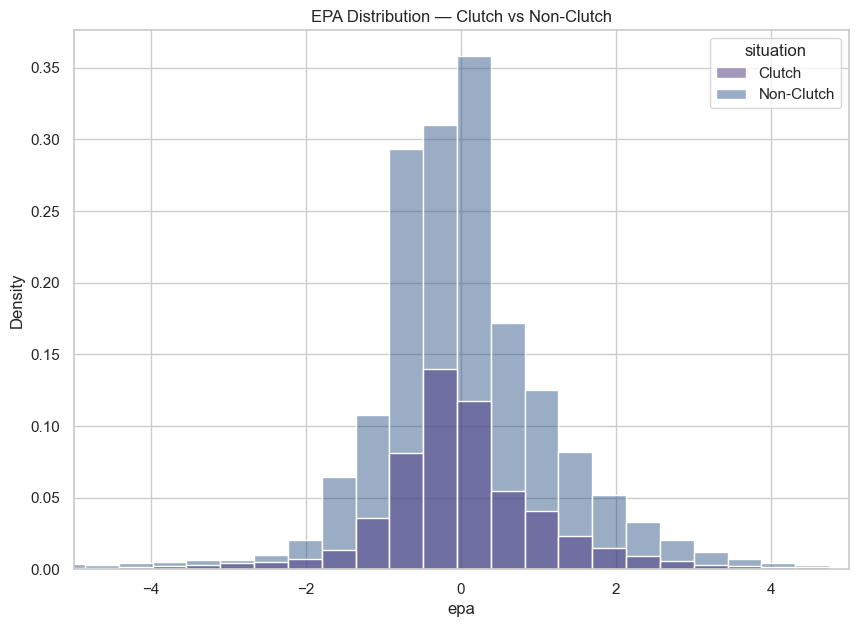

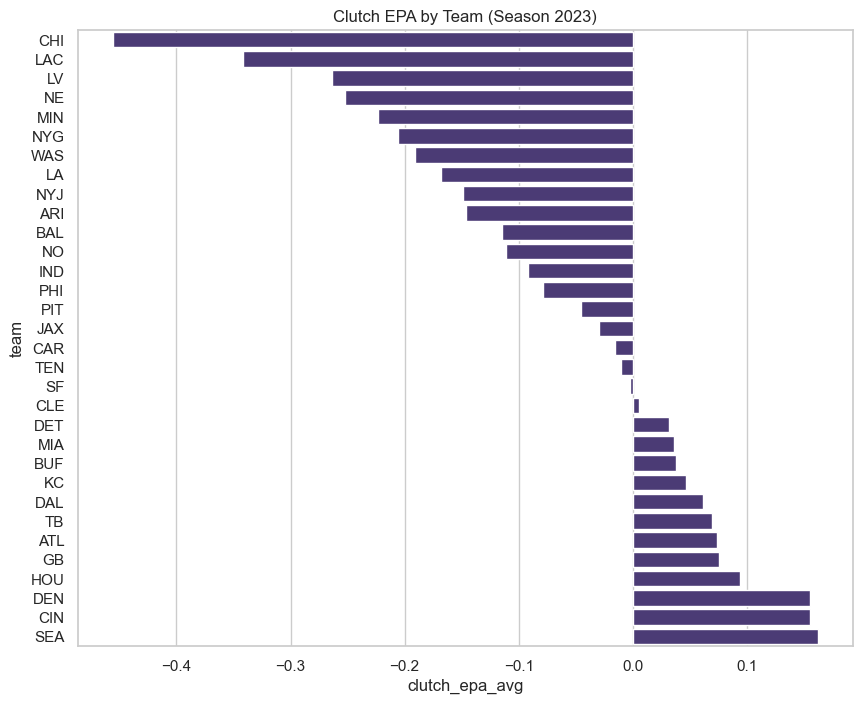

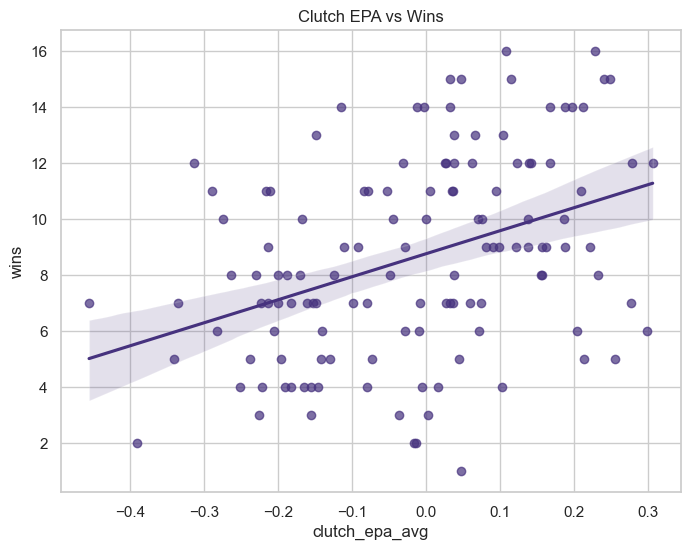

===== HEAD =====


,season,game_id,qtr,game_seconds_remaining,score_differential,posteam,defteam,home_team,away_team,home_score,away_score,epa,wpa,is_clutch
1,2019,2019_01_ATL_MIN,1,3600.0,0.0,ATL,MIN,MIN,ATL,28,12,0.000000,0.000000,False
2,2019,2019_01_ATL_MIN,1,3600.0,0.0,ATL,MIN,MIN,ATL,28,12,-1.658763,-0.035015,False
3,2019,2019_01_ATL_MIN,1,3560.0,0.0,ATL,MIN,MIN,ATL,28,12,-0.538914,-0.018435,False
4,2019,2019_01_ATL_MIN,1,3521.0,0.0,ATL,MIN,MIN,ATL,28,12,0.142138,0.018007,False
5,2019,2019_01_ATL_MIN,1,3479.0,0.0,ATL,MIN,MIN,ATL,28,12,-4.034299,-0.113866,False



===== SUMMARY =====


,season,qtr,game_seconds_remaining,score_differential,home_score,away_score,epa,wpa
count,181295.000000,181295.000000,181295.00000,181295.000000,181295.000000,181295.000000,181295.000000,181295.000000
mean,2020.779122,2.540434,1745.19006,-1.459902,23.959833,22.736330,-0.002938,0.000845
std,1.479901,1.124586,1041.55892,10.696310,10.132413,10.052614,1.295115,0.040171
min,2019.000000,1.000000,0.00000,-56.000000,0.000000,0.000000,-13.584859,-0.737291
25%,2020.000000,2.000000,855.00000,-7.000000,17.000000,16.000000,-0.581829,-0.014271
50%,2021.000000,2.000000,1803.00000,0.000000,24.000000,23.000000,-0.034859,-0.000019
75%,2023.000000,4.000000,2641.00000,4.000000,30.000000,30.000000,0.590608,0.011980
max,2023.000000,5.000000,3600.00000,55.000000,70.000000,59.000000,8.882384,0.944656



===== MISSING VALUES =====


season                    0
game_id                   0
qtr                       0
game_seconds_remaining    0
score_differential        0
posteam                   0
defteam                   0
home_team                 0
away_team                 0
home_score                0
away_score                0
epa                       0
wpa                       0
is_clutch                 0
dtype: int64

===== CLUTCH VS NON-CLUTCH =====


,Mean EPA,Std EPA,Count
Clutch,-0.014367,1.245143,9894
Non-Clutch,-0.002279,1.297942,171401


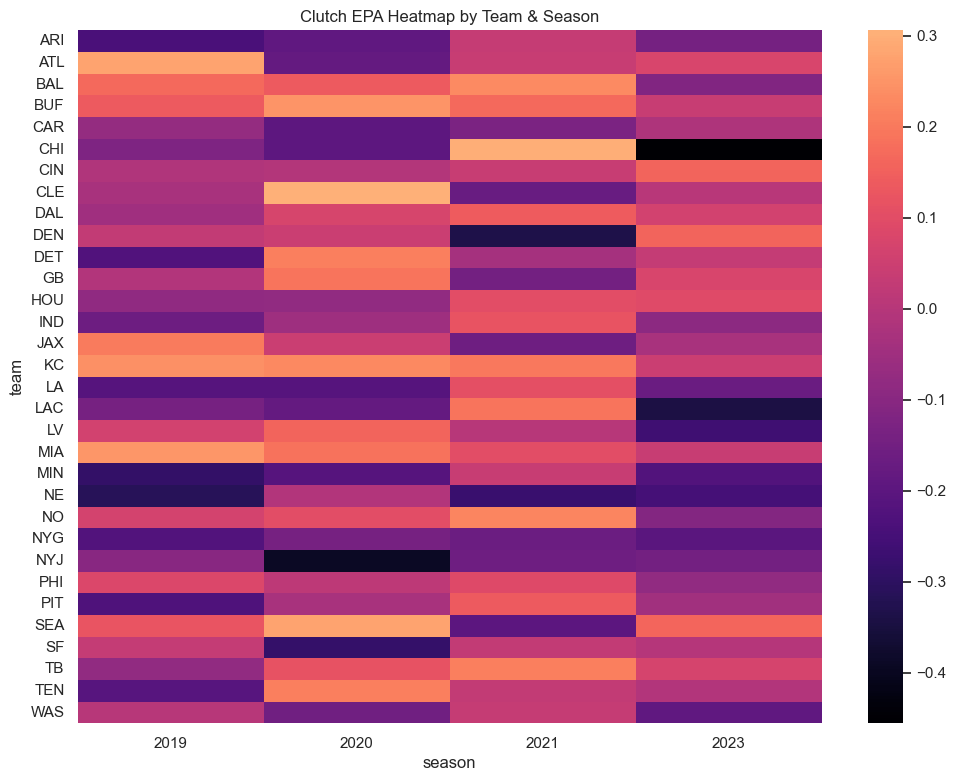

/var/folders/j9/y9drl51s2gvbm203cbmk7py80000gn/T/ipykernel_71478/2222944035.py:324: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


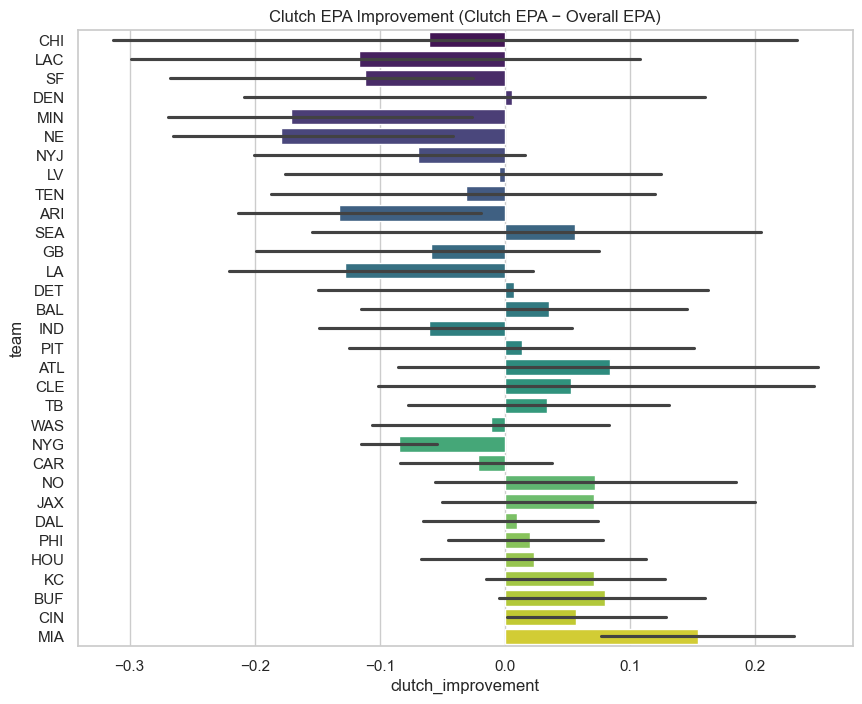


===== BEST CLUTCH TEAM (REAL DATA) =====
Team: SEA
Clutch EPA: 0.1619354368476224
Success Rate: 0.4807692307692308

Real Best Clutch Team: SEA

=== ADVANCED PREDICTION MODEL ===
Predicting Clutch EPA
R²: 0.8126171716994586
RMSE: 0.07263050895451344

=== FEATURE IMPORTANCE ===


,Feature,Importance
2,clutch_wpa_avg,0.754805
0,clutch_success_rate,0.139277
1,clutch_plays_count,0.046034
4,overall_epa,0.039720
3,wins,0.020164



=== PREDICTED BEST CLUTCH TEAM ===
Team: SEA
Predicted Clutch EPA: 0.12703221419364158

Predicted Best Clutch Team: SEA


In [11]:
# RUN EVERYTHING
main()